# Connectivity Prediction using CORNN

By Charles Xu @ Caltech

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.io import loadmat
from utils_admm import solve_corrn_admm
from utils_admm import solve_corrn_admm_gpu
from sklearn.metrics import r2_score

## Neural data

In [2]:
# Load data
data = loadmat('/Users/charlesxu/local/data/JK_functionalConn/CORNN_dev/JK_m3_fasted_processed_neuraldata_annot.mat')
print(data.keys())
print(data['annot'].shape, data['neuralData'].shape, data['rslds_output'].shape, data['stim'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'annot', 'neuralData', 'rslds_output', 'stim'])
(5, 8060) (8060, 54) (1, 1) (3, 8060)


In [155]:
# Import data
annot = data['annot']
neuralData = data['neuralData']
rslds_output = data['rslds_output']
stim = data['stim']

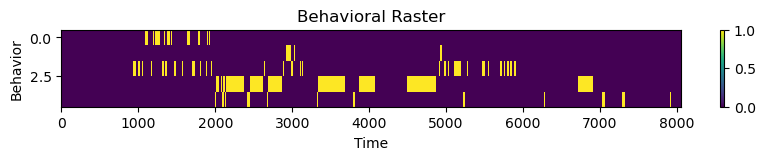

In [106]:
# Plot stimulus
plt.figure(figsize=(10, 1))
plt.imshow(annot, aspect='auto', interpolation='none')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Behavior')
plt.title('Behavioral Raster')
plt.show()

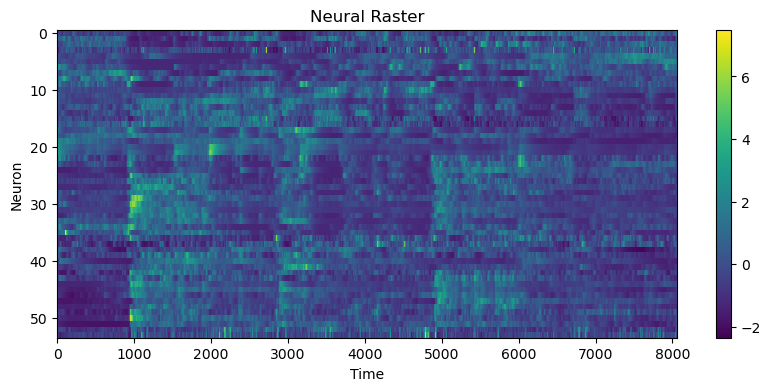

In [65]:
# Plot neural data
plt.figure(figsize=(10, 4))
plt.imshow(neuralData.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.title('Neural Raster')
plt.show()

## CORNN

In [69]:
r_in.shape, u_in.shape

((8059, 54), (8060, 4))

In [80]:
# Solve CoRNN
n_sup = neuralData.shape[1]
n_in = annot.shape[0]
r_in = neuralData[:-1, :]
r_out = neuralData[1:, :]
u_in = annot[:, 1:].T
w = solve_corrn_admm(r_in,
                     r_out,
                     u_in=u_in,
                     alph=0.1,
                     l2=1e-5,
                     threshold=1,
                     rho=1,
                     verbose=2,
                     check_convergence=0,
                     mask=None,
                     num_iters=0,
                     gnd=None,
                     solver_type='weighted')

w_rec_cornn = w[:n_sup, :].T
w_in_cornn = w[n_sup:, :].T

w_rec_cornn[np.eye(n_sup, dtype=bool)] = 0

17:23:15: Running CoRNN solver.
	 17:23:15: Performing initial inverse operations
	 17:23:16: Starting iterations
17:23:16: CoRNN solver finished in 0.01 mins


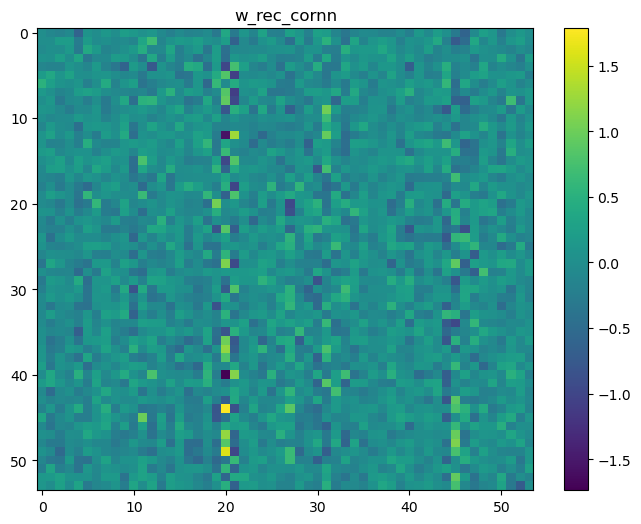

In [71]:
# Plot w_rec_cornn
plt.figure(figsize=(8, 6))
plt.imshow(w_rec_cornn, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('w_rec_cornn')
plt.show()

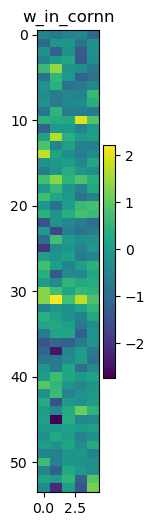

In [76]:
# Plot w_in_cornn
plt.figure(figsize=(1, 6))
plt.imshow(w_in_cornn, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('w_in_cornn')
plt.show()

In [77]:
# Solve CoRNN on GPU
n_sup = neuralData.shape[1]
r_in = neuralData[:-1, :]
r_out = neuralData[1:, :]
u_in = annot[:, 1:].T
w = solve_corrn_admm_gpu(r_in,
                         r_out,
                         u_in=u_in,
                         alph=0.1,
                         l2=1e-5,
                         threshold=1,
                         rho=1,
                         verbose=2,
                         mask=None,
                         float_type='32bit',
                         num_iters=0,
                         gnd=None,
                         solver_type='weighted')

w_rec_cornn = w[:n_sup, :].T
w_in_cornn = w[n_sup:, :].T

w_rec_cornn[np.eye(n_sup, dtype=bool)] = 0

17:20:40: Running CoRNN solver.
	 17:20:40: Performing initial inverse operations
	 17:20:40: Starting iterations
17:20:40: CoRNN solver finished in 0.00 mins


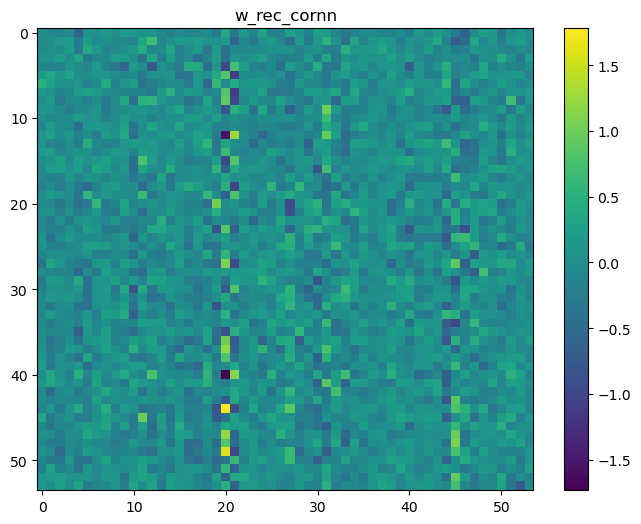

In [78]:
# Plot w_rec_cornn
plt.figure(figsize=(8, 6))
plt.imshow(w_rec_cornn, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('w_rec_cornn')
plt.show()

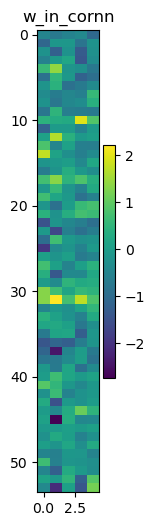

In [79]:
# Plot w_in_cornn
plt.figure(figsize=(1, 6))
plt.imshow(w_in_cornn, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('w_in_cornn')
plt.show()

## RNN simulation

RNN simulation using CORNN connectivity matrix

In [157]:
# Define the network
class Model(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, alpha=0.1):
        super(Model, self).__init__()
        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims
        self.alpha = alpha

        # Initialize weights
        self.W_in = nn.Parameter(torch.randn(hidden_dims, input_dims).to('mps'))
        self.W_rec = nn.Parameter(torch.randn(hidden_dims, hidden_dims).to('mps'))
        self.W_out = nn.Parameter(torch.randn(output_dims, hidden_dims).to('mps'))
        nn.init.xavier_uniform_(self.W_in)
        nn.init.xavier_uniform_(self.W_rec)
        nn.init.xavier_uniform_(self.W_out)

        # Set W_rec diagonal to zero
        self.W_rec.data = self.W_rec.data * (1 - torch.eye(hidden_dims).to('mps'))

    def forward(self, u, r, noise_in=0.1, noise_con=0):
        """
        Inputs
        The shape of u is (seq_len, input_dims)
        The shape of r is (hidden_dims), initialization of hidden dims
        
        Outputs
        The shape of o is (seq_len, output)
        The shape of hidden_states is (seq_len+1, hidden_dims)
        """
        T = u.shape[0]  # Sequence length
        n_rec = r.shape[0]  # Number of hidden dimensions
        
        hidden_states = torch.zeros([T+1, n_rec]).to('mps')
        hidden_states[0, :] = r.flatten().to('mps')
        x = torch.arctanh(r).to('mps')
        o = torch.zeros([T, self.output_dims]).to('mps')
        for t in range(T):
            x = (1 - self.alpha) * x + self.alpha * (self.W_rec @ r + self.W_in @ u[t, :] \
                + torch.normal(torch.zeros(n_rec), noise_in).to('mps'))
            r = torch.tanh(x).to('mps') + torch.normal(torch.zeros(n_rec), noise_con).to('mps')
            hidden_states[t+1, :] = r
            o[t, :] = self.W_out @ r.flatten()
                
        return hidden_states, o

In [158]:
u = torch.tensor(u_in, dtype=torch.float32).to('mps')
neuralData_normalized = 2 * (neuralData - np.min(neuralData)) / (np.max(neuralData) - np.min(neuralData)) - 1
r_init = torch.tensor(neuralData_normalized[0, :], dtype=torch.float32).to('mps')
model = Model(n_in, n_sup, 1)
model.W_in = nn.Parameter(torch.tensor(w_in_cornn, dtype=torch.float32).to('mps'))
model.W_rec = nn.Parameter(torch.tensor(w_rec_cornn, dtype=torch.float32).to('mps'))
h, out = model(u, r_init)

u = u.cpu().detach().numpy()
hidden_states = h.cpu().detach().numpy()
out = out.cpu().detach().numpy()

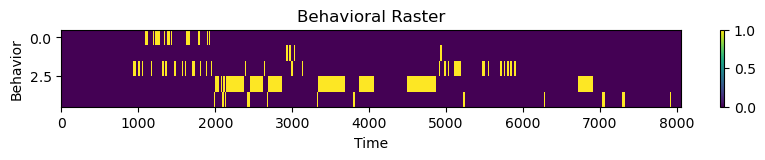

In [159]:
# Plot input
plt.figure(figsize=(10, 1))
plt.imshow(u.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Behavior')
plt.title('Behavioral Raster')
plt.show()

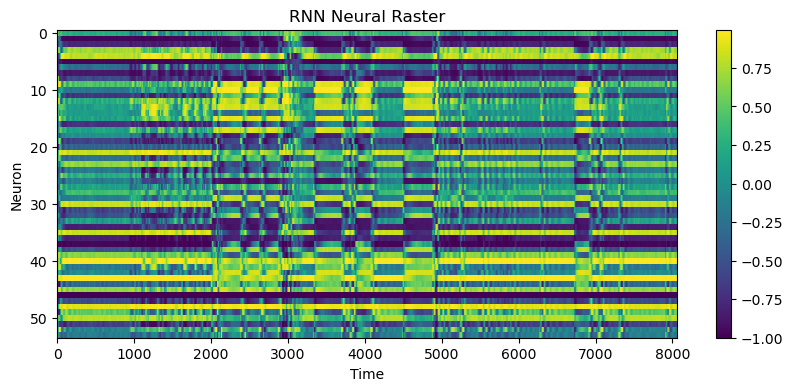

In [160]:
# Plot hidden states
plt.figure(figsize=(10, 4))
plt.imshow(hidden_states.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.xlabel('Time')
# plt.xlim([2000, 2020])
plt.ylabel('Neuron')
plt.title('RNN Neural Raster')
plt.show()

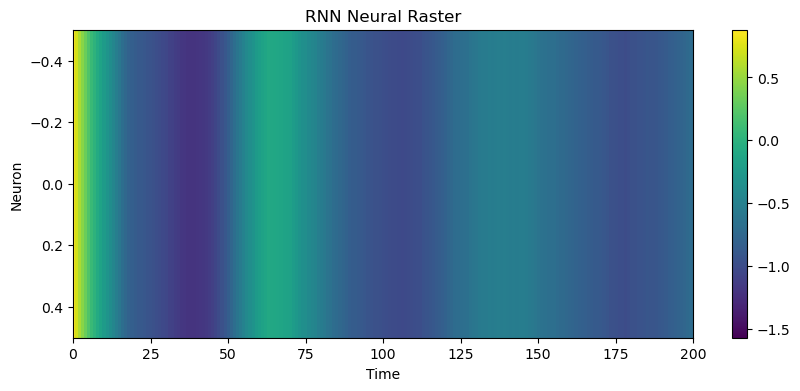

In [161]:
# Plot out
plt.figure(figsize=(10, 4))
plt.imshow(out.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.xlabel('Time')
plt.xlim([0, 200])
plt.ylabel('Neuron')
plt.title('RNN Neural Raster')
plt.show()

In [ ]:
# # Define the network
# class Model(nn.Module):
#     def __init__(self, input_dims=None, hidden_dims=None, output_dims=None, W_in=None, W_rec=None, W_out=None, alpha=0.1):
#         super(Model, self).__init__()
#         self.alpha = alpha

#         if W_in is not None and W_rec is not None and W_out is not None:
#             self.W_in = nn.Parameter(W_in.to('mps'))
#             self.W_rec = nn.Parameter(W_rec.to('mps'))
#             self.W_out = nn.Parameter(W_out.to('mps'))
#             self.input_dims = W_in.shape[1]
#             self.hidden_dims = W_in.shape[0]
#             self.output_dims = W_out.shape[0]
#         elif input_dims is not None and hidden_dims is not None and output_dims is not None:
#             self.input_dims = input_dims
#             self.hidden_dims = hidden_dims
#             self.output_dims = output_dims

#             # Initialize weights
#             self.W_in = nn.Parameter(torch.randn(hidden_dims, input_dims).to('mps'))
#             self.W_rec = nn.Parameter(torch.randn(hidden_dims, hidden_dims).to('mps'))
#             self.W_out = nn.Parameter(torch.randn(output_dims, hidden_dims).to('mps'))
#             nn.init.xavier_uniform_(self.W_in)
#             nn.init.xavier_uniform_(self.W_rec)
#             nn.init.xavier_uniform_(self.W_out)

#             # Set W_rec diagonal to zero
#             self.W_rec.data = self.W_rec.data * (1 - torch.eye(hidden_dims).to('mps'))
#         else:
#             raise ValueError("Either specify input_dims, hidden_dims, output_dims or W_in, W_rec, W_out")

#     def forward(self, u, r, noise_in=0.1, noise_con=0):
#         """
#         Inputs
#         The shape of u is (seq_len, input_dims)
#         The shape of r is (hidden_dims), initialization of hidden dims
        
#         Outputs
#         The shape of o is (seq_len, output)
#         The shape of hidden_states is (seq_len+1, hidden_dims)
#         """
#         T = u.shape[0]  # Sequence length
#         n_rec = r.shape[0]  # Number of hidden dimensions
        
#         hidden_states = torch.zeros([T+1, n_rec]).to('mps')
#         hidden_states[0, :] = r.flatten().to('mps')
#         x = torch.arctanh(r).to('mps')
#         o = torch.zeros([T, self.output_dims]).to('mps')
#         for t in range(T):
#             x = (1 - self.alpha) * x + self.alpha * (self.W_rec @ r + self.W_in @ u[t, :] \
#                 + torch.normal(torch.zeros(n_rec), noise_in).to('mps'))
#             r = torch.tanh(x).to('mps') + torch.normal(torch.zeros(n_rec), noise_con).to('mps')
#             hidden_states[t+1, :] = r
#             o[t, :] = self.W_out @ r.flatten()
                
#         return hidden_states, o

## Matrix decomposition

In [ ]:
w_rec_cornn